In [38]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [39]:
import pandas as pd
import numpy as np

from src import models
from src import experimental_setup
from src.helpers import init_layer, count_cf_bonds

# Experimental set-up

In [40]:
mordred = models.DNN_Mordred
sampling_type = 'random'

kfold = experimental_setup.CrossValidator(
    splits = 5, # dont change without re-running data preprocessing
    sampling_type = sampling_type
)

converter = experimental_setup.LD50UnitConverter()

# Transfer learning from base model

Our objective is to repurpose knowledge learned a source task (toxicity forecasting in *LDToxDB* chemical space) for use within desired target domain of *PFAS* toxicity prediction. We do this by retraining a model which demonstrated appreciable performance in the source domain to our target domain. Because labelled data are limited within our explicit target domain, we expand target task learning to any compound within LDToxDb which has 2 or more $C-F$ bonds.

Benchmark models were evaluated for their performance of predicting LDToxDB. The best performing NN from benchmarking is loaded as a checkpoint to use as a base model. The transfer step involves applying some set of modifications to the base model before retraining on target task data. Some techniques include adjusting learning rate, re-initialize MLP layers (randomize weights), freezing MLP layer weights. We reduce the learning rate by 10 and attempt several combinations of layer freezing and layer reinitialization.

<table>
    <tr style='font-weight:bold'><td>Level</td><td>Unfreeze last X hidden layers layers</td><td>Reinitialize last X hidden layers?</td></tr>
    <tr><td>1</td><td>1</td><td>No</td></tr>
    <tr><td>2</td><td>1</td><td>Yes</td></tr>
    <tr><td>3</td><td>2</td><td>No</td></tr>
    <tr><td>4</td><td>2</td><td>Yes</td></tr>
    <tr><td>5</td><td>3</td><td>No</td></tr>
    <tr><td>6</td><td>3</td><td>Yes</td></tr>
    <tr><td>7</td><td>4</td><td>No</td></tr>
    <tr><td>8</td><td>4</td><td>Yes</td></tr>
</table>

In [18]:
mordred_encoding = 'mordred'

for epochs in [100, 500]:
    for level in range(0,8):
        for fold_no, (train, test) in enumerate(kfold.get_folds(mordred_encoding, 'pfas_like')):
            x_train, y_train, smiles_train = train
            x_test, y_test, smiles_test = test
            
            y_train = experimental_setup.scaler.fit_transform(y_train)

            # Locate base model from benchmarks
            fn = 'dnn_mordred' + str(fold_no) + '_' + sampling_type
            model_path = '../data/benchmark-models/chkpts/%s.chkpt' % fn

            # Load weights file
            model = mordred()
            model.build(input_shape=x_train.shape)
            model.load_weights(model_path)

            # Modification to base model
            model.epochs = epochs
            
            last_x_layers = int(-2*np.floor(level / 2)) - 1

            for layer in model.layers[:last_x_layers]:
                layer.trainable = False

            if level % 2 == 1:
                for layer in model.layers[last_x_layers:]:
                    init_layer(layer)

            model.fit(x_train.astype(np.float32), y_train)

            # Save model
            fn += '_level' + str(level) + '_epochs' + str(epochs)
            model.save_weights('../data/transfer-learning/chkpts/%s' % fn)

            y_hat = experimental_setup.scaler.inverse_transform(model.predict(x_test))

            results = pd.DataFrame({
                'smiles': smiles_test.flatten(),
                'prediction_neglogld50': y_hat.flatten(),
                'prediction_mgkg': converter.convert_to_mgkg(y_hat, smiles_test),
                'prediction_epa': converter.convert_to_epa(y_hat, smiles_test),
                'actual_neglogld50': y_test.flatten(),
                'actual_mgkg': converter.convert_to_mgkg(y_test, smiles_test),
                'actual_epa': converter.convert_to_epa(y_test, smiles_test),
            })

            results.to_csv('../data/transfer-learning/%s_predictions.csv' % fn)

Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 0.5117 - mse: 0.5117 - mae: 0.6612
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1485 - mse: 0.1485 - mae: 0.3648
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1574 - mse: 0.1574 - mae: 0.3248
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1559 - mse: 0.1559 - mae: 0.3085
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1081 - mse: 0.1081 - mae: 0.2627
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.1183 - mse: 0.1183 - mae: 0.2746
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0750 - mse: 0.0750 - mae: 0.2221
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1564
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0610 - mse: 0.0610 - mae: 0.2005
Epoch 10/100
2/2 [============================

2/2 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0354
Epoch 54/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0352
Epoch 55/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0349
Epoch 56/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0346
Epoch 57/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0342
Epoch 58/100
2/2 [==============================] - 0s 1ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0339
Epoch 59/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0337
Epoch 60/100
2/2 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0336
Epoch 61/100
2/2 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0335
Epoch 62/100
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.4620 - mse: 0.4620 - mae: 0.6314
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1946 - mse: 0.1946 - mae: 0.4047
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2083 - mse: 0.2083 - mae: 0.3879
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1095 - mse: 0.1095 - mae: 0.2602
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1255 - mse: 0.1255 - mae: 0.2672
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1717 - mse: 0.1717 - mae: 0.3153
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0916 - mse: 0.0916 - mae: 0.2354
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0694 - mse: 0.0694 - mae: 0.2067
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0693 - mse: 0.0693 - mae: 0.2017
Epoch 10/100
2/2 [==============================] - 0s 2ms

2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0315
Epoch 78/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0314
Epoch 79/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0313
Epoch 80/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0312
Epoch 81/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0311
Epoch 82/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0309
Epoch 83/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0308
Epoch 84/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0307
Epoch 85/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0307
Epoch 86/100
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0613
Epoch 30/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0570
Epoch 31/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0616
Epoch 32/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0625
Epoch 33/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0573
Epoch 34/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0527
Epoch 35/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0518
Epoch 36/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0530
Epoch 37/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0514
Epoch 38/100
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 1.1202 - mse: 1.1202 - mae: 0.8718
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 0.3487 - mse: 0.3487 - mae: 0.4984
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 0.2558 - mse: 0.2558 - mae: 0.4046
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 0.4402 - mse: 0.4402 - mae: 0.5058
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 0.2875 - mse: 0.2875 - mae: 0.4088
Epoch 6/100
2/2 [==============================] - 0s 1ms/step - loss: 0.1164 - mse: 0.1164 - mae: 0.2652
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1496 - mse: 0.1496 - mae: 0.3205
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 0.2075 - mse: 0.2075 - mae: 0.3741
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1348 - mse: 0.1348 - mae: 0.3025
Epoch 10/100
2/2 [==============================] - 0s 1ms

2/2 [==============================] - 0s 2ms/step - loss: 0.0538 - mse: 0.0538 - mae: 0.1869
Epoch 14/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.1129
Epoch 15/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0356 - mae: 0.1567
Epoch 16/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0482 - mse: 0.0482 - mae: 0.1831
Epoch 17/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0305 - mse: 0.0305 - mae: 0.1453
Epoch 18/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0941
Epoch 19/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.1037
Epoch 20/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.1225
Epoch 21/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.1089
Epoch 22/100
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0300
Epoch 66/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0299
Epoch 67/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0298
Epoch 68/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0297
Epoch 69/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0296
Epoch 70/100
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0295
Epoch 71/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0295
Epoch 72/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0294
Epoch 73/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0293
Epoch 74/100
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.4433 - mse: 0.4433 - mae: 0.5596
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1503 - mse: 0.1503 - mae: 0.3301
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1892 - mse: 0.1892 - mae: 0.3666
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 0.1391 - mse: 0.1391 - mae: 0.3088
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0862 - mse: 0.0862 - mae: 0.2313
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1150 - mse: 0.1150 - mae: 0.2884
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0616 - mse: 0.0616 - mae: 0.2052
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0314 - mse: 0.0314 - mae: 0.1345
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0604 - mse: 0.0604 - mae: 0.1868
Epoch 10/100
2/2 [==============================] - 0s 2ms

2/2 [==============================] - 0s 2ms/step - loss: 7.5181e-04 - mse: 7.5181e-04 - mae: 0.0182
Epoch 50/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0966
Epoch 51/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0397    
Epoch 52/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.1190
Epoch 53/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0414
Epoch 54/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0521
Epoch 55/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0538
Epoch 56/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0997
Epoch 57/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0330
Epoch 58/100
2/2 [====================

2/2 [==============================] - 0s 3ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1250
Epoch 26/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0739
Epoch 27/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0300    
Epoch 28/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1277
Epoch 29/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0822
Epoch 30/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0604
Epoch 31/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0284    
Epoch 32/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0339
Epoch 33/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0551
Epoch 34/100
2/2 [========================

2/2 [==============================] - 0s 2ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1290
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.1080
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0809
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0942
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0868
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0688
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0707
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0726
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0813
Epoch 10/100
2/2 [==============================] - 0s 2ms

2/2 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0842
Epoch 49/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0329
Epoch 50/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0307
Epoch 51/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0274
Epoch 52/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0352
Epoch 53/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0599
Epoch 54/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 55/100
2/2 [==============================] - 0s 3ms/step - loss: 8.8177e-04 - mse: 8.8177e-04 - mae: 0.0184
Epoch 56/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0463
Epoch 57/100
2/2 [========================

2/2 [==============================] - 0s 4ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0768
Epoch 25/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0383
Epoch 26/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0314
Epoch 27/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0398
Epoch 28/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0333
Epoch 29/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0402
Epoch 30/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0536
Epoch 31/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0226    
Epoch 32/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0512
Epoch 33/100
2/2 [============================

2/2 [==============================] - 0s 4ms/step - loss: 7.8098e-04 - mse: 7.8098e-04 - mae: 0.0182
Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0334 - mse: 0.0334 - mae: 0.1436
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0883
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0745
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0935
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0579
Epoch 6/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0631
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0883
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0915
Epoch 9/100
2/2 [==============================] -

2/2 [==============================] - 0s 2ms/step - loss: 53.0356 - mse: 53.0356 - mae: 4.4203
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 12.0688 - mse: 12.0688 - mae: 2.5834
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 12.2045 - mse: 12.2045 - mae: 2.9800
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 5.0412 - mse: 5.0412 - mae: 1.6039
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 3.9037 - mse: 3.9037 - mae: 1.5350
Epoch 6/100
2/2 [==============================] - 0s 2ms/step - loss: 3.5641 - mse: 3.5641 - mae: 1.5633
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 1.7392 - mse: 1.7392 - mae: 0.9983
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 1.8425 - mse: 1.8425 - mae: 1.0736
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 1.6420 - mse: 1.6420 - mae: 1.0249
Epoch 10/100
2/2 [==============================] - 

2/2 [==============================] - 0s 2ms/step - loss: 6.6519 - mse: 6.6519 - mae: 2.0667
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 3.4709 - mse: 3.4709 - mae: 1.5694
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 1.0970 - mse: 1.0970 - mae: 0.7645
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 2.7922 - mse: 2.7922 - mae: 1.2626
Epoch 10/100
2/2 [==============================] - 0s 2ms/step - loss: 2.3341 - mse: 2.3341 - mae: 1.1619
Epoch 11/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7336 - mse: 0.7336 - mae: 0.6192
Epoch 12/100
2/2 [==============================] - 0s 2ms/step - loss: 0.9877 - mse: 0.9877 - mae: 0.7899
Epoch 13/100
2/2 [==============================] - 0s 2ms/step - loss: 1.3384 - mse: 1.3384 - mae: 0.8594
Epoch 14/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7537 - mse: 0.7537 - mae: 0.6443
Epoch 15/100
2/2 [==============================] - 0

2/2 [==============================] - 0s 2ms/step - loss: 0.1171 - mse: 0.1171 - mae: 0.2635
Epoch 59/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1282
Epoch 60/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0561 - mse: 0.0561 - mae: 0.1899
Epoch 61/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - mae: 0.1349
Epoch 62/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0464 - mse: 0.0464 - mae: 0.1670
Epoch 63/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0336 - mse: 0.0336 - mae: 0.1401
Epoch 64/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0280 - mse: 0.0280 - mae: 0.1227
Epoch 65/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - mae: 0.1445
Epoch 66/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0282 - mse: 0.0282 - mae: 0.1242
Epoch 67/100
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 56.9093 - mse: 56.9093 - mae: 4.7543
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 10.4072 - mse: 10.4072 - mae: 2.3189
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 13.1343 - mse: 13.1343 - mae: 2.8750
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 5.4732 - mse: 5.4732 - mae: 1.6998
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 4.1253 - mse: 4.1253 - mae: 1.7132
Epoch 6/100
2/2 [==============================] - 0s 2ms/step - loss: 3.3845 - mse: 3.3845 - mae: 1.4783
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 1.6994 - mse: 1.6994 - mae: 0.9376
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 1.6552 - mse: 1.6552 - mae: 1.0367
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 1.2611 - mse: 1.2611 - mae: 0.8424
Epoch 10/100
2/2 [==============================] - 

2/2 [==============================] - 0s 2ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0927
Epoch 89/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0828
Epoch 90/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0262 - mse: 0.0262 - mae: 0.1101
Epoch 91/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0953
Epoch 92/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0775
Epoch 93/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1180
Epoch 94/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.1032
Epoch 95/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0356 - mae: 0.1519
Epoch 96/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0847
Epoch 97/100
2/2 [==============================] 

2/2 [==============================] - 0s 3ms/step - loss: 0.0849 - mse: 0.0849 - mae: 0.2027
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0312 - mse: 0.0312 - mae: 0.1402
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1619
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0992
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0247 - mse: 0.0247 - mae: 0.1316
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0850
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1014
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0975
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0661
Epoch 10/100
2/2 [==============================] - 0s 3ms

2/2 [==============================] - 0s 3ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.1189
Epoch 53/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0409
Epoch 54/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0544
Epoch 55/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0546
Epoch 56/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0997
Epoch 57/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0320
Epoch 58/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.1150
Epoch 59/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.1267
Epoch 60/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0642
Epoch 61/100
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.0326 - mse: 0.0326 - mae: 0.1314
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1027
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0206 - mse: 0.0206 - mae: 0.1096
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0821
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0892
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0748
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0932
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0749
Epoch 11/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0568
Epoch 12/100
2/2 [==============================] - 0s 2

2/2 [==============================] - 0s 3ms/step - loss: 0.0559 - mse: 0.0559 - mae: 0.1762
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0246 - mse: 0.0246 - mae: 0.1308
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0366 - mse: 0.0366 - mae: 0.1567
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.1016
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1381
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.1055
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.1020
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0813
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0622
Epoch 10/100
2/2 [==============================] - 0s 3ms

2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0319    
Epoch 34/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0405
Epoch 35/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0338
Epoch 36/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0426
Epoch 37/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0250
Epoch 38/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0420
Epoch 39/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0542
Epoch 40/100
2/2 [==============================] - 0s 4ms/step - loss: 6.9898e-04 - mse: 6.9898e-04 - mae: 0.0179
Epoch 41/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0237    
Epoch 42/100
2/2 [================

2/2 [==============================] - 0s 3ms/step - loss: 23.6803 - mse: 23.6803 - mae: 3.2471
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 78.1901 - mse: 78.1901 - mae: 6.4951
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 36.7233 - mse: 36.7233 - mae: 4.7010
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 28.7895 - mse: 28.7895 - mae: 3.8065
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 3.4081 - mse: 3.4081 - mae: 1.3455
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 17.4498 - mse: 17.4498 - mae: 3.3169
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 10.8833 - mse: 10.8833 - mae: 2.5402
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 1.7789 - mse: 1.7789 - mae: 0.9990
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 4.3431 - mse: 4.3431 - mae: 1.5080
Epoch 10/100
2/2 [============================

2/2 [==============================] - 0s 3ms/step - loss: 3.2232 - mse: 3.2232 - mae: 1.1511
Epoch 13/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7129 - mse: 0.7129 - mae: 0.5930
Epoch 14/100
2/2 [==============================] - 0s 3ms/step - loss: 0.5156 - mse: 0.5156 - mae: 0.5397
Epoch 15/100
2/2 [==============================] - 0s 3ms/step - loss: 1.3929 - mse: 1.3929 - mae: 0.8960
Epoch 16/100
2/2 [==============================] - 0s 3ms/step - loss: 1.9452 - mse: 1.9452 - mae: 1.0299
Epoch 17/100
2/2 [==============================] - 0s 3ms/step - loss: 1.6817 - mse: 1.6817 - mae: 0.9587
Epoch 18/100
2/2 [==============================] - 0s 2ms/step - loss: 1.0197 - mse: 1.0197 - mae: 0.7654
Epoch 19/100
2/2 [==============================] - 0s 3ms/step - loss: 0.4558 - mse: 0.4558 - mae: 0.5124
Epoch 20/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2468 - mse: 0.2468 - mae: 0.3824
Epoch 21/100
2/2 [==============================] 

2/2 [==============================] - 0s 3ms/step - loss: 0.0823 - mse: 0.0823 - mae: 0.2188
Epoch 64/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0797 - mse: 0.0797 - mae: 0.2181
Epoch 65/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0761 - mse: 0.0761 - mae: 0.2154
Epoch 66/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0721 - mse: 0.0721 - mae: 0.2046
Epoch 67/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0779 - mse: 0.0779 - mae: 0.2150
Epoch 68/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0740 - mse: 0.0740 - mae: 0.2144
Epoch 69/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0717 - mse: 0.0717 - mae: 0.2096
Epoch 70/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0696 - mse: 0.0696 - mae: 0.2085
Epoch 71/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0663 - mse: 0.0663 - mae: 0.1997
Epoch 72/100
2/2 [==============================] 

2/2 [==============================] - 0s 4ms/step - loss: 14.0949 - mse: 14.0949 - mae: 2.5222
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 58.3602 - mse: 58.3602 - mae: 5.3376
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 30.8915 - mse: 30.8915 - mae: 4.2520
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 15.4255 - mse: 15.4255 - mae: 2.6450
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 6.8180 - mse: 6.8180 - mae: 2.1252
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 11.8993 - mse: 11.8993 - mae: 2.7779
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 3.4198 - mse: 3.4198 - mae: 1.3977
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 2.0531 - mse: 2.0531 - mae: 1.1659
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 3.6140 - mse: 3.6140 - mae: 1.4710
Epoch 10/100
2/2 [==============================

2/2 [==============================] - 0s 3ms/step - loss: 0.7519 - mse: 0.7519 - mae: 0.6242
Epoch 19/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2369 - mse: 0.2369 - mae: 0.3867
Epoch 20/100
2/2 [==============================] - 0s 2ms/step - loss: 0.3369 - mse: 0.3369 - mae: 0.4454
Epoch 21/100
2/2 [==============================] - 0s 2ms/step - loss: 0.5243 - mse: 0.5243 - mae: 0.5774
Epoch 22/100
2/2 [==============================] - 0s 3ms/step - loss: 0.4812 - mse: 0.4812 - mae: 0.5269
Epoch 23/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2758 - mse: 0.2758 - mae: 0.4113
Epoch 24/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2141 - mse: 0.2141 - mae: 0.3689
Epoch 25/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2595 - mse: 0.2595 - mae: 0.4143
Epoch 26/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2763 - mse: 0.2763 - mae: 0.4273
Epoch 27/100
2/2 [==============================] 

2/2 [==============================] - 0s 4ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0553
Epoch 22/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0858
Epoch 23/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0724
Epoch 24/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0358
Epoch 25/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0286
Epoch 26/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0494
Epoch 27/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0403
Epoch 28/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0602
Epoch 29/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0445
Epoch 30/100
2/2 [==============================] 

2/2 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0357    
Epoch 98/100
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.031 - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0356
Epoch 99/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0382
Epoch 100/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0340
Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0502 - mse: 0.0502 - mae: 0.1633
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.1148
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.1005
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0811
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.099

Epoch 73/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0331
Epoch 74/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0324
Epoch 75/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0493
Epoch 76/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0322    
Epoch 77/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0664
Epoch 78/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0354
Epoch 79/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0298
Epoch 80/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.1093
Epoch 81/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0670
Epoch 82/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 0.0920 - mse: 0.0920 - mae: 0.2253
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1267
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1386
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0239 - mse: 0.0239 - mae: 0.1178
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1214
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0181 - mse: 0.0181 - mae: 0.1029
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1065
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0702
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0765
Epoch 10/100
2/2 [==============================] - 0s 4ms

2/2 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0490
Epoch 29/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0355
Epoch 30/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0563
Epoch 31/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0781
Epoch 32/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0438
Epoch 33/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0285
Epoch 34/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0412
Epoch 35/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0373
Epoch 36/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0419
Epoch 37/100
2/2 [==============================] 

2/2 [==============================] - 0s 3ms/step - loss: 10.4032 - mse: 10.4032 - mae: 2.3449
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 40.7365 - mse: 40.7365 - mae: 4.5346
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 31.9558 - mse: 31.9558 - mae: 4.4134
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 3.4985 - mse: 3.4985 - mae: 1.3451
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 2.2239 - mse: 2.2239 - mae: 1.0600
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 1.9478 - mse: 1.9478 - mae: 0.9356
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2645 - mse: 1.2645 - mae: 0.7622
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7010 - mse: 0.7010 - mae: 0.6374
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.5385 - mse: 0.5385 - mae: 0.5551
Epoch 10/100
2/2 [==============================] - 

2/2 [==============================] - 0s 4ms/step - loss: 0.1402 - mse: 0.1402 - mae: 0.2973
Epoch 49/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1256 - mse: 0.1256 - mae: 0.2744
Epoch 50/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1406 - mse: 0.1406 - mae: 0.2906
Epoch 51/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1274 - mse: 0.1274 - mae: 0.2778
Epoch 52/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1404 - mse: 0.1404 - mae: 0.2901
Epoch 53/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1184 - mse: 0.1184 - mae: 0.2677
Epoch 54/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1183 - mse: 0.1183 - mae: 0.2670
Epoch 55/100
2/2 [==============================] - 0s 4ms/step - loss: 0.1107 - mse: 0.1107 - mae: 0.2572
Epoch 56/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1300 - mse: 0.1300 - mae: 0.2781
Epoch 57/100
2/2 [==============================] 

2/2 [==============================] - 0s 3ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1499
Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 11.2213 - mse: 11.2213 - mae: 2.3744
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 22.0068 - mse: 22.0068 - mae: 3.3906
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 21.6535 - mse: 21.6535 - mae: 3.7584
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6788 - mse: 1.6788 - mae: 1.0271
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 3.1265 - mse: 3.1265 - mae: 1.4210
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2906 - mse: 1.2906 - mae: 0.8736
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9819 - mse: 0.9819 - mae: 0.7855
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4015 - mse: 1.4015 - mae: 0.9568
Epoch 9/100
2/2 [==============================] - 0

2/2 [==============================] - 0s 3ms/step - loss: 0.3547 - mse: 0.3547 - mae: 0.4584
Epoch 20/100
2/2 [==============================] - 0s 4ms/step - loss: 0.3316 - mse: 0.3316 - mae: 0.4498
Epoch 21/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2927 - mse: 0.2927 - mae: 0.4260
Epoch 22/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3233 - mse: 0.3233 - mae: 0.4397
Epoch 23/100
2/2 [==============================] - 0s 4ms/step - loss: 0.2772 - mse: 0.2772 - mae: 0.4190
Epoch 24/100
2/2 [==============================] - 0s 4ms/step - loss: 0.2718 - mse: 0.2718 - mae: 0.4119
Epoch 25/100
2/2 [==============================] - 0s 4ms/step - loss: 0.2481 - mse: 0.2481 - mae: 0.4004
Epoch 26/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2565 - mse: 0.2565 - mae: 0.4066
Epoch 27/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2406 - mse: 0.2406 - mae: 0.3941
Epoch 28/100
2/2 [==============================] 

2/2 [==============================] - 0s 4ms/step - loss: 0.1711 - mse: 0.1711 - mae: 0.3135
Epoch 39/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1720 - mse: 0.1720 - mae: 0.3192
Epoch 40/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1599 - mse: 0.1599 - mae: 0.3036
Epoch 41/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1585 - mse: 0.1585 - mae: 0.3036
Epoch 42/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1592 - mse: 0.1592 - mae: 0.3029
Epoch 43/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1577 - mse: 0.1577 - mae: 0.3022
Epoch 44/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1494 - mse: 0.1494 - mae: 0.2938
Epoch 45/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1481 - mse: 0.1481 - mae: 0.2904
Epoch 46/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1538 - mse: 0.1538 - mae: 0.3005
Epoch 47/100
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0324
Epoch 91/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0324
Epoch 92/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0323
Epoch 93/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0323
Epoch 94/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0323
Epoch 95/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0322
Epoch 96/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0321
Epoch 97/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0319
Epoch 98/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0319
Epoch 99/500
2/2 [==============================] 

2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0292
Epoch 167/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0291
Epoch 168/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0291
Epoch 169/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 170/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 171/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 172/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 173/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0291
Epoch 174/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 175/500
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 242/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 243/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0280
Epoch 244/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0280
Epoch 245/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 246/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 247/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0280
Epoch 248/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0280
Epoch 249/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0279
Epoch 250/500
2/2 [=======================

Epoch 392/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0270
Epoch 393/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0270
Epoch 394/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0268
Epoch 395/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0268
Epoch 396/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0268
Epoch 397/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0268
Epoch 398/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0268
Epoch 399/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0268
Epoch 400/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269    
Epoch 401/500
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0404
Epoch 44/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0399
Epoch 45/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0393
Epoch 46/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0387
Epoch 47/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0379
Epoch 48/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0373
Epoch 49/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0370
Epoch 50/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0366
Epoch 51/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0361
Epoch 52/500
2/2 [==============================] 

Epoch 195/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0279
Epoch 196/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0277
Epoch 197/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0276
Epoch 198/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0276
Epoch 199/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0276
Epoch 200/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0276
Epoch 201/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0277
Epoch 202/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0278
Epoch 203/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0278
Epoch 204/500
2/2 [=========

2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0267
Epoch 346/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0266
Epoch 347/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0266
Epoch 348/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0266
Epoch 349/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0266
Epoch 350/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0266
Epoch 351/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0269
Epoch 352/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0267
Epoch 353/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0267
Epoch 354/500
2/2 [=======================

Epoch 421/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0264
Epoch 422/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263
Epoch 423/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263
Epoch 424/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263
Epoch 425/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0262
Epoch 426/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0262
Epoch 427/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0262
Epoch 428/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0264
Epoch 429/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0265
Epoch 430/500
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.4642 - mse: 0.4642 - mae: 0.6438
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1329 - mse: 0.1329 - mae: 0.3191
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2082 - mse: 0.2082 - mae: 0.3554
Epoch 4/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1470 - mse: 0.1470 - mae: 0.3123
Epoch 5/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1115 - mse: 0.1115 - mae: 0.2591
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1379 - mse: 0.1379 - mae: 0.2917
Epoch 7/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0591 - mse: 0.0591 - mae: 0.1904
Epoch 8/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0254 - mse: 0.0254 - mae: 0.1233
Epoch 9/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0662 - mse: 0.0662 - mae: 0.2044
Epoch 10/500
2/2 [==============================] - 0s 2ms

2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0314
Epoch 128/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0313
Epoch 129/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0312
Epoch 130/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0312
Epoch 131/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0311
Epoch 132/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0311
Epoch 133/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0310
Epoch 134/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0310
Epoch 135/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0309
Epoch 136/500
2/2 [=======================

Epoch 203/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0283
Epoch 204/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0282
Epoch 205/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0282
Epoch 206/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0282
Epoch 207/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 208/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0282
Epoch 209/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 210/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 211/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0281
Epoch 212/500
2/2 [=========

2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0253
Epoch 354/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0253
Epoch 355/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0252
Epoch 356/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0252
Epoch 357/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0253
Epoch 358/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0253
Epoch 359/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0252
Epoch 360/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0253
Epoch 361/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0252
Epoch 362/500
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 0.2083 - mse: 0.2083 - mae: 0.3879
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1095 - mse: 0.1095 - mae: 0.2602
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1255 - mse: 0.1255 - mae: 0.2672
Epoch 6/500
2/2 [==============================] - 0s 4ms/step - loss: 0.1717 - mse: 0.1717 - mae: 0.3153
Epoch 7/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0916 - mse: 0.0916 - mae: 0.2354
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0694 - mse: 0.0694 - mae: 0.2067
Epoch 9/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0693 - mse: 0.0693 - mae: 0.2017
Epoch 10/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0384 - mae: 0.1445
Epoch 11/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0485 - mse: 0.0485 - mae: 0.1876
Epoch 12/500
2/2 [==============================] - 0s 2

2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0270
Epoch 156/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 157/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0270
Epoch 158/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 159/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 160/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 161/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 162/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 163/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 164/500
2/2 [=======================

Epoch 231/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0257    
Epoch 232/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0258
Epoch 233/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0258
Epoch 234/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0258
Epoch 235/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0258
Epoch 236/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0258
Epoch 237/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0257
Epoch 238/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0257
Epoch 239/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0257
Epoch 240/500
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0249
Epoch 382/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0248
Epoch 383/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0249
Epoch 384/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0249
Epoch 385/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0249
Epoch 386/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0249
Epoch 387/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0248
Epoch 388/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0248
Epoch 389/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0249
Epoch 390/500
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0377
Epoch 32/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0362
Epoch 33/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0365
Epoch 34/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0360
Epoch 35/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0351
Epoch 36/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0348
Epoch 37/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0338
Epoch 38/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0331
Epoch 39/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0329
Epoch 40/500
2/2 [==============================] 

2/2 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0248
Epoch 183/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0247    
Epoch 184/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0246
Epoch 185/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0246
Epoch 186/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0247
Epoch 187/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0247
Epoch 188/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0247
Epoch 189/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0246
Epoch 190/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0245
Epoch 191/500
2/2 [===================

2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0233
Epoch 332/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0232
Epoch 333/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0232
Epoch 334/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0233
Epoch 335/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0232
Epoch 336/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0233    
Epoch 337/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0232
Epoch 338/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0231
Epoch 339/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0231    
Epoch 340/500
2/2 [===============

2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0225
Epoch 481/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0225
Epoch 482/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0225
Epoch 483/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0225
Epoch 484/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0225
Epoch 485/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0225    
Epoch 486/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0226    
Epoch 487/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0226    
Epoch 488/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0226
Epoch 489/500
2/2 [===========

2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0304
Epoch 133/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0303
Epoch 134/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0302
Epoch 135/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0301
Epoch 136/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0301
Epoch 137/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0300
Epoch 138/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0299
Epoch 139/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0299
Epoch 140/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0299
Epoch 141/500
2/2 [=======================

Epoch 208/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0276
Epoch 209/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277
Epoch 210/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0276
Epoch 211/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0276
Epoch 212/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0275
Epoch 213/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0275
Epoch 214/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0275
Epoch 215/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0275
Epoch 216/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0274
Epoch 217/500
2/2 [=========

2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261
Epoch 359/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261
Epoch 360/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261
Epoch 361/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261
Epoch 362/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0260
Epoch 363/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261
Epoch 364/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261
Epoch 365/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261
Epoch 366/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261
Epoch 367/500
2/2 [=======================

Epoch 1/500
2/2 [==============================] - 0s 1ms/step - loss: 1.1202 - mse: 1.1202 - mae: 0.8718
Epoch 2/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3487 - mse: 0.3487 - mae: 0.4984
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2558 - mse: 0.2558 - mae: 0.4046
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 0.4402 - mse: 0.4402 - mae: 0.5058
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2875 - mse: 0.2875 - mae: 0.4088
Epoch 6/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1164 - mse: 0.1164 - mae: 0.2652
Epoch 7/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1496 - mse: 0.1496 - mae: 0.3205
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2075 - mse: 0.2075 - mae: 0.3741
Epoch 9/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1348 - mse: 0.1348 - mae: 0.3025
Epoch 10/500
2/2 [============================

2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0286
Epoch 117/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0286
Epoch 118/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0285
Epoch 119/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0284
Epoch 120/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0284
Epoch 121/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0284
Epoch 122/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0284
Epoch 123/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0284
Epoch 124/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0284
Epoch 125/500
2/2 [=======================

Epoch 192/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0273
Epoch 193/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0273
Epoch 194/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0273
Epoch 195/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0273
Epoch 196/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0274
Epoch 197/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0274
Epoch 198/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0274
Epoch 199/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0273
Epoch 200/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0273
Epoch 201/500
2/2 [=========

2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0264
Epoch 343/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0264
Epoch 344/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263
Epoch 345/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0264
Epoch 346/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263
Epoch 347/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263
Epoch 348/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263
Epoch 349/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0264
Epoch 350/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263
Epoch 351/500
2/2 [=======================

Epoch 493/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0260
Epoch 494/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0259
Epoch 495/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0260
Epoch 496/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0259
Epoch 497/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0259
Epoch 498/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0261
Epoch 499/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0262
Epoch 500/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0261
Epoch 1/500
2/2 [==============================] - 0s 2ms/step - loss: 1.2212 - mse: 1.2212 - mae: 0.8689
Epoch 2/500
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0292
Epoch 146/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0291
Epoch 147/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0291
Epoch 148/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0291
Epoch 149/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 150/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 151/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290
Epoch 152/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0289
Epoch 153/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0288
Epoch 154/500
2/2 [=======================

Epoch 221/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 222/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 223/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 224/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 225/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 226/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 227/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 228/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269
Epoch 229/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0268
Epoch 230/500
2/2 [=========

2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0248
Epoch 372/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0247
Epoch 373/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0247
Epoch 374/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0247
Epoch 375/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0246
Epoch 376/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0246
Epoch 377/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0246
Epoch 378/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0247
Epoch 379/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0247
Epoch 380/500
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0883
Epoch 22/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0754
Epoch 23/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0511
Epoch 24/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0591
Epoch 25/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0671
Epoch 26/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0562
Epoch 27/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0456
Epoch 28/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0489
Epoch 29/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0490
Epoch 30/500
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0260
Epoch 174/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0259
Epoch 175/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0259
Epoch 176/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0259
Epoch 177/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0259
Epoch 178/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0258
Epoch 179/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0259
Epoch 180/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0259
Epoch 181/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0259
Epoch 182/500
2/2 [=======================

Epoch 324/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0250
Epoch 325/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0250
Epoch 326/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0250
Epoch 327/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0250
Epoch 328/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0251
Epoch 329/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0250
Epoch 330/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0249
Epoch 331/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0250
Epoch 332/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0250
Epoch 333/500
2/2 [=========

2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0247
Epoch 475/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0247
Epoch 476/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0246
Epoch 477/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0246
Epoch 478/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0246
Epoch 479/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0245
Epoch 480/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0246
Epoch 481/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0245
Epoch 482/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0246
Epoch 483/500
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 0.4433 - mse: 0.4433 - mae: 0.5596
Epoch 2/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1503 - mse: 0.1503 - mae: 0.3301
Epoch 3/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1892 - mse: 0.1892 - mae: 0.3666
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1391 - mse: 0.1391 - mae: 0.3088
Epoch 5/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0862 - mse: 0.0862 - mae: 0.2313
Epoch 6/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1150 - mse: 0.1150 - mae: 0.2884
Epoch 7/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0616 - mse: 0.0616 - mae: 0.2052
Epoch 8/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0314 - mse: 0.0314 - mae: 0.1345
Epoch 9/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0604 - mse: 0.0604 - mae: 0.1868
Epoch 10/500
2/2 [==============================] - 0s 2ms

2/2 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0306
Epoch 43/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0302
Epoch 44/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0303
Epoch 45/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0303
Epoch 46/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0300
Epoch 47/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0301
Epoch 48/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0300
Epoch 49/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0297
Epoch 50/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0295
Epoch 51/500
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0244
Epoch 194/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0244    
Epoch 195/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0244
Epoch 196/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0244
Epoch 197/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0244
Epoch 198/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0243
Epoch 199/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0243
Epoch 200/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0243
Epoch 201/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0243
Epoch 202/500
2/2 [===================

2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0232
Epoch 342/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0231
Epoch 343/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0231    
Epoch 344/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0232
Epoch 345/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0232
Epoch 346/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0232
Epoch 347/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0231
Epoch 348/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0230    
Epoch 349/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0231
Epoch 350/500
2/2 [===============

2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0228    
Epoch 417/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0227
Epoch 418/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0228    
Epoch 419/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0229
Epoch 420/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0228
Epoch 421/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0228
Epoch 422/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0228
Epoch 423/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0228
Epoch 424/500
2/2 [==============================] - 0s 1ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0229    
Epoch 425/500
2/2 [===========

2/2 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0466
Epoch 67/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0321    
Epoch 68/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0377    
Epoch 69/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0825
Epoch 70/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0845
Epoch 71/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0234
Epoch 72/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0548
Epoch 73/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0547
Epoch 74/500
2/2 [==============================] - 0s 2ms/step - loss: 9.7600e-04 - mse: 9.7600e-04 - mae: 0.0223
Epoch 75/500
2/2 [================

2/2 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0775
Epoch 213/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0331
Epoch 214/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0709
Epoch 215/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0909
Epoch 216/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0529
Epoch 217/500
2/2 [==============================] - 0s 2ms/step - loss: 6.5042e-04 - mse: 6.5042e-04 - mae: 0.0170
Epoch 218/500
2/2 [==============================] - 0s 2ms/step - loss: 7.2193e-04 - mse: 7.2193e-04 - mae: 0.0183
Epoch 219/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0456
Epoch 220/500
2/2 [==============================] - 0s 2ms/step - loss: 7.9091e-04 - mse: 7.9091e-04 - mae: 0.0185
Epoch 221/500
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0634
Epoch 287/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.1103
Epoch 288/500
2/2 [==============================] - 0s 2ms/step - loss: 8.3486e-04 - mse: 8.3486e-04 - mae: 0.0212
Epoch 289/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0253    
Epoch 290/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0439
Epoch 291/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0244    
Epoch 292/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.1078
Epoch 293/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0194    
Epoch 294/500
2/2 [==============================] - 0s 2ms/step - loss: 6.7488e-04 - mse: 6.7488e-04 - mae: 0.0171
Epoch 295/500


2/2 [==============================] - 0s 2ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0747
Epoch 434/500
2/2 [==============================] - 0s 2ms/step - loss: 9.1787e-04 - mse: 9.1787e-04 - mae: 0.0209
Epoch 435/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0354    
Epoch 436/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0831
Epoch 437/500
2/2 [==============================] - 0s 2ms/step - loss: 8.1822e-04 - mse: 8.1822e-04 - mae: 0.0194
Epoch 438/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0770
Epoch 439/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0490
Epoch 440/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0502
Epoch 441/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0485
Epoch 442/500
2/2 [===

2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0256
Epoch 83/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0374    
Epoch 84/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0406    
Epoch 85/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0260    
Epoch 86/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0381
Epoch 87/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0263
Epoch 88/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0283    
Epoch 89/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0319    
Epoch 90/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0363    
Epoch 91/500
2/2 [========

2/2 [==============================] - 0s 2ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0553
Epoch 231/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0311    
Epoch 232/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0564
Epoch 233/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0347
Epoch 234/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0471
Epoch 235/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0333
Epoch 236/500
2/2 [==============================] - 0s 2ms/step - loss: 9.8166e-04 - mse: 9.8166e-04 - mae: 0.0238
Epoch 237/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0421
Epoch 238/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0402
Epoch 239/500
2/2 [===========

2/2 [==============================] - 0s 2ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.1184
Epoch 378/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0371    
Epoch 379/500
2/2 [==============================] - 0s 2ms/step - loss: 7.8581e-04 - mse: 7.8581e-04 - mae: 0.0210
Epoch 380/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0737
Epoch 381/500
2/2 [==============================] - 0s 2ms/step - loss: 5.3494e-04 - mse: 5.3494e-04 - mae: 0.0138
Epoch 382/500
2/2 [==============================] - 0s 2ms/step - loss: 5.3666e-04 - mse: 5.3666e-04 - mae: 0.0146
Epoch 383/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0294    
Epoch 384/500
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.029 - 0s 2ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0489
Epoch 385/500
2/2 [==============================] - 0s 2ms/step -

Epoch 1/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1290
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.1080
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0809
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0942
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0868
Epoch 6/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0688
Epoch 7/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0707
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0726
Epoch 9/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0813
Epoch 10/500
2/2 [============================

2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0386
Epoch 149/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.1093
Epoch 150/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0630
Epoch 151/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0268
Epoch 152/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0551
Epoch 153/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0222    
Epoch 154/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0251
Epoch 155/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0477
Epoch 156/500
2/2 [==============================] - 0s 2ms/step - loss: 9.9281e-04 - mse: 9.9281e-04 - mae: 0.0194
Epoch 157/500
2/2 [===========

2/2 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0489
Epoch 298/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0266    
Epoch 299/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0750
Epoch 300/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0301
Epoch 301/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0588
Epoch 302/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0340
Epoch 303/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0509
Epoch 304/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0234    
Epoch 305/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0341
Epoch 306/500
2/2 [===============

2/2 [==============================] - 0s 2ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0589
Epoch 448/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0333
Epoch 449/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0481
Epoch 450/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.1013
Epoch 451/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0589
Epoch 452/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0325    
Epoch 453/500
2/2 [==============================] - 0s 2ms/step - loss: 8.7627e-04 - mse: 8.7627e-04 - mae: 0.0194
Epoch 454/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0515
Epoch 455/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0375
Epoch 456/500
2/2 [===========

2/2 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0429
Epoch 98/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0922
Epoch 99/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0528
Epoch 100/500
2/2 [==============================] - 0s 2ms/step - loss: 7.8098e-04 - mse: 7.8098e-04 - mae: 0.0182
Epoch 101/500
2/2 [==============================] - 0s 2ms/step - loss: 8.6875e-04 - mse: 8.6875e-04 - mae: 0.0197
Epoch 102/500
2/2 [==============================] - 0s 2ms/step - loss: 7.4852e-04 - mse: 7.4852e-04 - mae: 0.0170
Epoch 103/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0313    
Epoch 104/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0381    
Epoch 105/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0294
Epoch 106/50

2/2 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0876
Epoch 245/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0320    
Epoch 246/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0610
Epoch 247/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0378    
Epoch 248/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0391
Epoch 249/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0280    
Epoch 250/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0931
Epoch 251/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0448
Epoch 252/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0414
Epoch 253/500
2/2 [===========

2/2 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0418
Epoch 392/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0648
Epoch 393/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0278
Epoch 394/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0885
Epoch 395/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0538
Epoch 396/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0920
Epoch 397/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0680
Epoch 398/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0360    
Epoch 399/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0518
Epoch 400/500
2/2 [===================

2/2 [==============================] - 0s 2ms/step - loss: 0.0334 - mse: 0.0334 - mae: 0.1436
Epoch 2/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0883
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0745
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0935
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0579
Epoch 6/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0631
Epoch 7/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0883
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0915
Epoch 9/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0452
Epoch 10/500
2/2 [==============================] - 0s 2ms

2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0380
Epoch 127/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0315
Epoch 128/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0462
Epoch 129/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0746
Epoch 130/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0536
Epoch 131/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0251
Epoch 132/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0279
Epoch 133/500
2/2 [==============================] - 0s 2ms/step - loss: 5.8061e-04 - mse: 5.8061e-04 - mae: 0.0150
Epoch 134/500
2/2 [==============================] - 0s 2ms/step - loss: 9.5673e-04 - mse: 9.5673e-04 - mae: 0.0237
Epoch 135/500
2/2 [=======

2/2 [==============================] - 0s 3ms/step - loss: 7.4207e-04 - mse: 7.4207e-04 - mae: 0.0179
Epoch 275/500
2/2 [==============================] - 0s 2ms/step - loss: 9.8128e-04 - mse: 9.8128e-04 - mae: 0.0216
Epoch 276/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0498
Epoch 277/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0686
Epoch 278/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0276
Epoch 279/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0496
Epoch 280/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.1238
Epoch 281/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0297    
Epoch 282/500
2/2 [==============================] - 0s 2ms/step - loss: 9.3341e-04 - mse: 9.3341e-04 - mae: 0.0204
Epoch 283/500


2/2 [==============================] - 0s 2ms/step - loss: 9.7427e-04 - mse: 9.7427e-04 - mae: 0.0245
Epoch 349/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0545
Epoch 350/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0239    
Epoch 351/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0350    
Epoch 352/500
2/2 [==============================] - 0s 2ms/step - loss: 9.1291e-04 - mse: 9.1291e-04 - mae: 0.0193
Epoch 353/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0264    
Epoch 354/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0784
Epoch 355/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.1115
Epoch 356/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0553
Epoch 357/500


2/2 [==============================] - 0s 2ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0771
Epoch 423/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0412    
Epoch 424/500
2/2 [==============================] - 0s 2ms/step - loss: 9.8630e-04 - mse: 9.8630e-04 - mae: 0.0187
Epoch 425/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0676
Epoch 426/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0503
Epoch 427/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0835
Epoch 428/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0558
Epoch 429/500
2/2 [==============================] - 0s 2ms/step - loss: 7.4594e-04 - mse: 7.4594e-04 - mae: 0.0187
Epoch 430/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0575
Epoch 431/500
2/2 [===

2/2 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1503
Epoch 72/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0599 - mse: 0.0599 - mae: 0.1828
Epoch 73/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0292 - mse: 0.0292 - mae: 0.1150
Epoch 74/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0483 - mse: 0.0483 - mae: 0.1855
Epoch 75/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0261 - mse: 0.0261 - mae: 0.1174
Epoch 76/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0742 - mse: 0.0742 - mae: 0.2282
Epoch 77/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0889
Epoch 78/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0349 - mse: 0.0349 - mae: 0.1333
Epoch 79/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0263 - mse: 0.0263 - mae: 0.1185
Epoch 80/500
2/2 [==============================] 

Epoch 222/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.1030
Epoch 223/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0930
Epoch 224/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1073
Epoch 225/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1123
Epoch 226/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0227 - mse: 0.0227 - mae: 0.1149
Epoch 227/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0269 - mse: 0.0269 - mae: 0.1392
Epoch 228/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0630
Epoch 229/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0939
Epoch 230/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0988
Epoch 231/500
2/2 [=========

2/2 [==============================] - 0s 2ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0929
Epoch 373/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0297 - mse: 0.0297 - mae: 0.1483
Epoch 374/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0877
Epoch 375/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.1184
Epoch 376/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0965
Epoch 377/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.1026
Epoch 378/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1215
Epoch 379/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0736
Epoch 380/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0973
Epoch 381/500
2/2 [=======================

Epoch 448/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1838
Epoch 449/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0898
Epoch 450/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0547
Epoch 451/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0755
Epoch 452/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.1008
Epoch 453/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0986
Epoch 454/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0542
Epoch 455/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0948
Epoch 456/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0848
Epoch 457/500
2/2 [=========

2/2 [==============================] - 0s 2ms/step - loss: 0.1910 - mse: 0.1910 - mae: 0.3293
Epoch 25/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2081 - mse: 0.2081 - mae: 0.3692
Epoch 26/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1317 - mse: 0.1317 - mae: 0.2608
Epoch 27/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1397 - mse: 0.1397 - mae: 0.3182
Epoch 28/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0842 - mse: 0.0842 - mae: 0.2167
Epoch 29/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1656 - mse: 0.1656 - mae: 0.3239
Epoch 30/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1272 - mse: 0.1272 - mae: 0.2866
Epoch 31/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0981 - mse: 0.0981 - mae: 0.2620
Epoch 32/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1140 - mse: 0.1140 - mae: 0.2669
Epoch 33/500
2/2 [==============================] 

Epoch 176/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0798
Epoch 177/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0181 - mse: 0.0181 - mae: 0.0904
Epoch 178/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0720
Epoch 179/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.1099
Epoch 180/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0785
Epoch 181/500
2/2 [==============================] - ETA: 0s - loss: 0.0139 - mse: 0.0139 - mae: 0.093 - 0s 2ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0993
Epoch 182/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0905
Epoch 183/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0270 - mse: 0.0270 - mae: 0.1196
Epoch 184/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0217 - ms

2/2 [==============================] - 0s 2ms/step - loss: 0.0253 - mse: 0.0253 - mae: 0.1284
Epoch 327/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.1035
Epoch 328/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1184
Epoch 329/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0189 - mse: 0.0189 - mae: 0.1222
Epoch 330/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.1012
Epoch 331/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.1252
Epoch 332/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0797
Epoch 333/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0875
Epoch 334/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0834
Epoch 335/500
2/2 [=======================

Epoch 402/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0729
Epoch 403/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0945
Epoch 404/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0633
Epoch 405/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0967
Epoch 406/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0751
Epoch 407/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0985
Epoch 408/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0605
Epoch 409/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1139
Epoch 410/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0704
Epoch 411/500
2/2 [=========

2/2 [==============================] - 0s 6ms/step - loss: 63.7377 - mse: 63.7377 - mae: 5.3505
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 13.2132 - mse: 13.2132 - mae: 2.7276
Epoch 3/500
2/2 [==============================] - 0s 4ms/step - loss: 22.0403 - mse: 22.0403 - mae: 3.9879
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 14.0936 - mse: 14.0936 - mae: 2.9363
Epoch 5/500
2/2 [==============================] - 0s 5ms/step - loss: 2.4992 - mse: 2.4992 - mae: 1.2064
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 7.1827 - mse: 7.1827 - mae: 2.1549
Epoch 7/500
2/2 [==============================] - 0s 4ms/step - loss: 5.3833 - mse: 5.3833 - mae: 1.9077
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 1.4985 - mse: 1.4985 - mae: 0.9766
Epoch 9/500
2/2 [==============================] - 0s 4ms/step - loss: 1.7307 - mse: 1.7307 - mae: 0.9668
Epoch 10/500
2/2 [==============================] 

2/2 [==============================] - 0s 2ms/step - loss: 0.0234 - mse: 0.0234 - mae: 0.1081
Epoch 109/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0719 - mse: 0.0719 - mae: 0.2013
Epoch 110/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1076
Epoch 111/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.0937
Epoch 112/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0867
Epoch 113/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0854
Epoch 114/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0660 - mse: 0.0660 - mae: 0.2029
Epoch 115/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0494 - mse: 0.0494 - mae: 0.1269
Epoch 116/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0330 - mse: 0.0330 - mae: 0.1487
Epoch 117/500
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0882
Epoch 259/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0864
Epoch 260/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0858
Epoch 261/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0755
Epoch 262/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0614
Epoch 263/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0723
Epoch 264/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0839
Epoch 265/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0905
Epoch 266/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0965
Epoch 267/500
2/2 [=======================

Epoch 334/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0681
Epoch 335/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.1190
Epoch 336/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0244 - mse: 0.0244 - mae: 0.1409
Epoch 337/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0722
Epoch 338/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0774
Epoch 339/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0522
Epoch 340/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0654
Epoch 341/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0487
Epoch 342/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0754
Epoch 343/500
2/2 [=========

Epoch 485/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.0653
Epoch 486/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0676
Epoch 487/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0609
Epoch 488/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0413
Epoch 489/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0504
Epoch 490/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0759
Epoch 491/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0434
Epoch 492/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0619
Epoch 493/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0440
Epoch 494/500
2/2 [=========

2/2 [==============================] - 0s 2ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0879
Epoch 137/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0622
Epoch 138/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0919
Epoch 139/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0791
Epoch 140/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0832
Epoch 141/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0753
Epoch 142/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0767
Epoch 143/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0846
Epoch 144/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0564
Epoch 145/500
2/2 [=======================

Epoch 212/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0822
Epoch 213/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0281 - mse: 0.0281 - mae: 0.1195
Epoch 214/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0859
Epoch 215/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.1009
Epoch 216/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1045
Epoch 217/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.1087
Epoch 218/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0249 - mse: 0.0249 - mae: 0.1098
Epoch 219/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1315
Epoch 220/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0962
Epoch 221/500
2/2 [=========

Epoch 363/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0517
Epoch 364/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1230
Epoch 365/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0235 - mse: 0.0235 - mae: 0.1279
Epoch 366/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1198
Epoch 367/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0573
Epoch 368/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0818
Epoch 369/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0552
Epoch 370/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1312
Epoch 371/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0660
Epoch 372/500
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.4236 - mse: 0.4236 - mae: 0.4848
Epoch 14/500
2/2 [==============================] - 0s 2ms/step - loss: 0.4131 - mse: 0.4131 - mae: 0.4794
Epoch 15/500
2/2 [==============================] - 0s 4ms/step - loss: 0.3874 - mse: 0.3874 - mae: 0.4781
Epoch 16/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3805 - mse: 0.3805 - mae: 0.4785
Epoch 17/500
2/2 [==============================] - 0s 3ms/step - loss: 0.2817 - mse: 0.2817 - mae: 0.3851
Epoch 18/500
2/2 [==============================] - 0s 4ms/step - loss: 0.1790 - mse: 0.1790 - mae: 0.3206
Epoch 19/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2238 - mse: 0.2238 - mae: 0.3789
Epoch 20/500
2/2 [==============================] - 0s 4ms/step - loss: 0.1955 - mse: 0.1955 - mae: 0.3457
Epoch 21/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1271 - mse: 0.1271 - mae: 0.2872
Epoch 22/500
2/2 [==============================] 

2/2 [==============================] - 0s 3ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1010
Epoch 166/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0782
Epoch 167/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0817
Epoch 168/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0918
Epoch 169/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0763
Epoch 170/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1029
Epoch 171/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0893
Epoch 172/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0972
Epoch 173/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0966
Epoch 174/500
2/2 [=======================

Epoch 241/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0896
Epoch 242/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0889
Epoch 243/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.1018
Epoch 244/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0585
Epoch 245/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1238
Epoch 246/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0314 - mse: 0.0314 - mae: 0.1563
Epoch 247/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1084
Epoch 248/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1449
Epoch 249/500
2/2 [==============================] - ETA: 0s - loss: 0.0154 - mse: 0.0154 - mae: 0.107 - 0s 2ms/step - loss: 0.0131 - ms

2/2 [==============================] - 0s 3ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0988
Epoch 392/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0828
Epoch 393/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0599
Epoch 394/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1307
Epoch 395/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0816
Epoch 396/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0947
Epoch 397/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0858
Epoch 398/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0590
Epoch 399/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0735
Epoch 400/500
2/2 [=======================

Epoch 467/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0876
Epoch 468/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0980
Epoch 469/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.1049
Epoch 470/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0613
Epoch 471/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0711
Epoch 472/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0828
Epoch 473/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.0977
Epoch 474/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0581
Epoch 475/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0993
Epoch 476/500
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.0849 - mse: 0.0849 - mae: 0.2027
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0312 - mse: 0.0312 - mae: 0.1402
Epoch 3/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1619
Epoch 4/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0992
Epoch 5/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0247 - mse: 0.0247 - mae: 0.1316
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0850
Epoch 7/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1014
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0975
Epoch 9/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0661
Epoch 10/500
2/2 [==============================] - 0s 3ms

2/2 [==============================] - 0s 6ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0308
Epoch 98/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0340
Epoch 99/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0365
Epoch 100/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0314
Epoch 101/500
2/2 [==============================] - 0s 3ms/step - loss: 8.5861e-04 - mse: 8.5861e-04 - mae: 0.0190
Epoch 102/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0883
Epoch 103/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0795
Epoch 104/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0861
Epoch 105/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0285
Epoch 106/500
2/2 [=================

2/2 [==============================] - 0s 3ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0833
Epoch 245/500
2/2 [==============================] - 0s 5ms/step - loss: 8.9258e-04 - mse: 8.9258e-04 - mae: 0.0201
Epoch 246/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0411
Epoch 247/500
2/2 [==============================] - 0s 6ms/step - loss: 6.9033e-04 - mse: 6.9033e-04 - mae: 0.0168
Epoch 248/500
2/2 [==============================] - 0s 3ms/step - loss: 7.3589e-04 - mse: 7.3589e-04 - mae: 0.0169
Epoch 249/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0216    
Epoch 250/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0241    
Epoch 251/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0264
Epoch 252/500
2/2 [==============================] - 0s 6ms/step - loss: 6.8324e-04 - mse: 6.8324e-04 - mae: 0.0160
Ep

2/2 [==============================] - 0s 2ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0718
Epoch 390/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0236    
Epoch 391/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0289
Epoch 392/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0449
Epoch 393/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0488
Epoch 394/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0275
Epoch 395/500
2/2 [==============================] - 0s 3ms/step - loss: 8.0320e-04 - mse: 8.0320e-04 - mae: 0.0196
Epoch 396/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0366
Epoch 397/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0488
Epoch 398/500
2/2 [===========

2/2 [==============================] - 0s 4ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0295
Epoch 37/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0438
Epoch 38/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0326    
Epoch 39/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0249
Epoch 40/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0359
Epoch 41/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0394
Epoch 42/500
2/2 [==============================] - 0s 3ms/step - loss: 8.5700e-04 - mse: 8.5700e-04 - mae: 0.0201
Epoch 43/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0587
Epoch 44/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0642
Epoch 45/500
2/2 [====================

2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0283
Epoch 185/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0785
Epoch 186/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0834
Epoch 187/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0553
Epoch 188/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0737
Epoch 189/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0275
Epoch 190/500
2/2 [==============================] - 0s 3ms/step - loss: 9.7411e-04 - mse: 9.7411e-04 - mae: 0.0229
Epoch 191/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0622
Epoch 192/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0876
Epoch 193/500
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 7.1089e-04 - mse: 7.1089e-04 - mae: 0.0187
Epoch 333/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0259    
Epoch 334/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0687
Epoch 335/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0354
Epoch 336/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0636
Epoch 337/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290    
Epoch 338/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0403
Epoch 339/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0368
Epoch 340/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0392
Epoch 341/500
2/2 [=======

2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0349
Epoch 481/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0222    
Epoch 482/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.1180
Epoch 483/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0491
Epoch 484/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0371
Epoch 485/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0291    
Epoch 486/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0779
Epoch 487/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0647
Epoch 488/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0269
Epoch 489/500
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0892
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0748
Epoch 9/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0932
Epoch 10/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0749
Epoch 11/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0568
Epoch 12/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0741
Epoch 13/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0557
Epoch 14/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0356
Epoch 15/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0566
Epoch 16/500
2/2 [==============================] - 

2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0308
Epoch 159/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0359
Epoch 160/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287
Epoch 161/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0331
Epoch 162/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0230
Epoch 163/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0313
Epoch 164/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0536
Epoch 165/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0237    
Epoch 166/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0601
Epoch 167/500
2/2 [===================

2/2 [==============================] - 0s 3ms/step - loss: 9.3256e-04 - mse: 9.3256e-04 - mae: 0.0196
Epoch 309/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0304
Epoch 310/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0221    
Epoch 311/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0585
Epoch 312/500
2/2 [==============================] - 0s 3ms/step - loss: 7.9846e-04 - mse: 7.9846e-04 - mae: 0.0170
Epoch 313/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0268
Epoch 314/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0398
Epoch 315/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0323
Epoch 316/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0253    
Epoch 317/500
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0455
Epoch 458/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0520
Epoch 459/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0213    
Epoch 460/500
2/2 [==============================] - 0s 3ms/step - loss: 9.7617e-04 - mse: 9.7617e-04 - mae: 0.0191
Epoch 461/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0327
Epoch 462/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0409
Epoch 463/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0256
Epoch 464/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0220    
Epoch 465/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0215    
Epoch 466/500
2/2 [===

2/2 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0260    
Epoch 107/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0276    
Epoch 108/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0500
Epoch 109/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0793
Epoch 110/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0332
Epoch 111/500
2/2 [==============================] - 0s 3ms/step - loss: 8.9920e-04 - mse: 8.9920e-04 - mae: 0.0210
Epoch 112/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0876
Epoch 113/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0250
Epoch 114/500
2/2 [==============================] - 0s 3ms/step - loss: 9.6361e-04 - mse: 9.6361e-04 - mae: 0.0211
Epoch 115/500
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0271
Epoch 254/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0212    
Epoch 255/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0386
Epoch 256/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0728
Epoch 257/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0893
Epoch 258/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0601
Epoch 259/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0237    
Epoch 260/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0398    
Epoch 261/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0595
Epoch 262/500
2/2 [===========

2/2 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0383
Epoch 401/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0530
Epoch 402/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0271
Epoch 403/500
2/2 [==============================] - 0s 3ms/step - loss: 9.1019e-04 - mse: 9.1019e-04 - mae: 0.0226
Epoch 404/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0878
Epoch 405/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0964
Epoch 406/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0586
Epoch 407/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.1234
Epoch 408/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.1265
Epoch 409/500
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0627
Epoch 475/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0842
Epoch 476/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0268    
Epoch 477/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0840
Epoch 478/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0403    
Epoch 479/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0651
Epoch 480/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0669
Epoch 481/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0698
Epoch 482/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0337
Epoch 483/500
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0257
Epoch 125/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0449
Epoch 126/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0378
Epoch 127/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0324
Epoch 128/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0462
Epoch 129/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0742
Epoch 130/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0536
Epoch 131/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0238
Epoch 132/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0302
Epoch 133/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0224    
Epoch 272/500
2/2 [==============================] - 0s 3ms/step - loss: 6.8112e-04 - mse: 6.8112e-04 - mae: 0.0173
Epoch 273/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0524
Epoch 274/500
2/2 [==============================] - 0s 3ms/step - loss: 5.7034e-04 - mse: 5.7034e-04 - mae: 0.0146
Epoch 275/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0234    
Epoch 276/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0496
Epoch 277/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0683
Epoch 278/500
2/2 [==============================] - 0s 3ms/step - loss: 9.4998e-04 - mse: 9.4998e-04 - mae: 0.0233
Epoch 279/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0491
Epoch 280/

2/2 [==============================] - 0s 3ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0712
Epoch 418/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0237    
Epoch 419/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0232    
Epoch 420/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0259    
Epoch 421/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0320
Epoch 422/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0773
Epoch 423/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0416
Epoch 424/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0199    
Epoch 425/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0674
Epoch 426/500
2/2 [=======

2/2 [==============================] - 0s 3ms/step - loss: 23.6803 - mse: 23.6803 - mae: 3.2471
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 78.1901 - mse: 78.1901 - mae: 6.4951
Epoch 3/500
2/2 [==============================] - 0s 3ms/step - loss: 36.7233 - mse: 36.7233 - mae: 4.7010
Epoch 4/500
2/2 [==============================] - 0s 3ms/step - loss: 28.7895 - mse: 28.7895 - mae: 3.8065
Epoch 5/500
2/2 [==============================] - 0s 3ms/step - loss: 3.4081 - mse: 3.4081 - mae: 1.3455
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 17.4498 - mse: 17.4498 - mae: 3.3169
Epoch 7/500
2/2 [==============================] - 0s 3ms/step - loss: 10.8833 - mse: 10.8833 - mae: 2.5402
Epoch 8/500
2/2 [==============================] - 0s 5ms/step - loss: 1.7789 - mse: 1.7789 - mae: 0.9990
Epoch 9/500
2/2 [==============================] - 0s 3ms/step - loss: 4.3431 - mse: 4.3431 - mae: 1.5080
Epoch 10/500
2/2 [============================

2/2 [==============================] - 0s 3ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1254
Epoch 145/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0404 - mse: 0.0404 - mae: 0.1513
Epoch 146/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0227 - mse: 0.0227 - mae: 0.1193
Epoch 147/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1227
Epoch 148/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0281 - mse: 0.0281 - mae: 0.1355
Epoch 149/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1191
Epoch 150/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.1070
Epoch 151/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0189 - mse: 0.0189 - mae: 0.1079
Epoch 152/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0184 - mse: 0.0184 - mae: 0.1064
Epoch 153/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0993
Epoch 220/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0877
Epoch 221/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0265 - mse: 0.0265 - mae: 0.1241
Epoch 222/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0893
Epoch 223/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0250 - mse: 0.0250 - mae: 0.1205
Epoch 224/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0931
Epoch 225/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0221 - mse: 0.0221 - mae: 0.1153
Epoch 226/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0262 - mse: 0.0262 - mae: 0.1288
Epoch 227/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0807
Epoch 228/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0910
Epoch 370/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0854
Epoch 371/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1193
Epoch 372/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0729
Epoch 373/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1107
Epoch 374/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0775
Epoch 375/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1198
Epoch 376/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0601
Epoch 377/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0580
Epoch 378/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0499
Epoch 445/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0470
Epoch 446/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0210 - mse: 0.0210 - mae: 0.1242
Epoch 447/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0741
Epoch 448/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0261 - mse: 0.0261 - mae: 0.1403
Epoch 449/500
2/2 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0114 - mae: 0.078 - 0s 3ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0853
Epoch 450/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0531
Epoch 451/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0580
Epoch 452/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0144 - mse: 0.0144 - ma

2/2 [==============================] - 0s 3ms/step - loss: 0.0801 - mse: 0.0801 - mae: 0.2174
Epoch 96/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0884 - mse: 0.0884 - mae: 0.2312
Epoch 97/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0831 - mse: 0.0831 - mae: 0.2280
Epoch 98/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0813 - mse: 0.0813 - mae: 0.2217
Epoch 99/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0800 - mse: 0.0800 - mae: 0.2206
Epoch 100/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0712 - mse: 0.0712 - mae: 0.2059
Epoch 101/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0750 - mse: 0.0750 - mae: 0.2142
Epoch 102/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0784 - mse: 0.0784 - mae: 0.2187
Epoch 103/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0793 - mse: 0.0793 - mae: 0.2198
Epoch 104/500
2/2 [===========================

2/2 [==============================] - 0s 3ms/step - loss: 0.0420 - mse: 0.0420 - mae: 0.1533
Epoch 172/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0454 - mse: 0.0454 - mae: 0.1636
Epoch 173/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1755
Epoch 174/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0415 - mse: 0.0415 - mae: 0.1523
Epoch 175/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1619
Epoch 176/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0418 - mse: 0.0418 - mae: 0.1534
Epoch 177/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1496
Epoch 178/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0391 - mse: 0.0391 - mae: 0.1473
Epoch 179/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0480 - mse: 0.0480 - mae: 0.1696
Epoch 180/500
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.1061
Epoch 322/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0334 - mse: 0.0334 - mae: 0.1475
Epoch 323/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0253 - mse: 0.0253 - mae: 0.1238
Epoch 324/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0943
Epoch 325/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0913
Epoch 326/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0962
Epoch 327/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0966
Epoch 328/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.1107
Epoch 329/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0899
Epoch 330/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.1191
Epoch 472/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0672
Epoch 473/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0711
Epoch 474/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0713
Epoch 475/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0684
Epoch 476/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0591
Epoch 477/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0698
Epoch 478/500
2/2 [==============================] - ETA: 0s - loss: 0.0108 - mse: 0.0108 - mae: 0.083 - 0s 3ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.1094
Epoch 479/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0090 - mse: 0.0090 - ma

2/2 [==============================] - 0s 3ms/step - loss: 19.9626 - mse: 19.9626 - mae: 3.0168
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 61.6350 - mse: 61.6350 - mae: 5.7954
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 42.3399 - mse: 42.3399 - mae: 5.2775
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 21.2245 - mse: 21.2245 - mae: 3.4169
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 4.8175 - mse: 4.8175 - mae: 1.6851
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 14.4942 - mse: 14.4942 - mae: 3.0029
Epoch 7/500
2/2 [==============================] - 0s 3ms/step - loss: 7.3621 - mse: 7.3621 - mae: 2.0682
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 2.6034 - mse: 2.6034 - mae: 1.2284
Epoch 9/500
2/2 [==============================] - 0s 2ms/step - loss: 4.0282 - mse: 4.0282 - mae: 1.3522
Epoch 10/500
2/2 [==============================

2/2 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0359 - mae: 0.1442
Epoch 153/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1098
Epoch 154/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0253 - mse: 0.0253 - mae: 0.1266
Epoch 155/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0268 - mse: 0.0268 - mae: 0.1285
Epoch 156/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1063
Epoch 157/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1274
Epoch 158/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1135
Epoch 159/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0248 - mse: 0.0248 - mae: 0.1231
Epoch 160/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0236 - mse: 0.0236 - mae: 0.1188
Epoch 161/500
2/2 [=======================

Epoch 228/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0901
Epoch 229/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0911
Epoch 230/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0893
Epoch 231/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0870
Epoch 232/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0999
Epoch 233/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0864
Epoch 234/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0993
Epoch 235/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0944
Epoch 236/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0885
Epoch 237/500
2/2 [=========

2/2 [==============================] - 0s 7ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.1060
Epoch 378/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0373 - mse: 0.0373 - mae: 0.1567
Epoch 379/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0983
Epoch 380/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0675
Epoch 381/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0767
Epoch 382/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0675
Epoch 383/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0817
Epoch 384/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0802
Epoch 385/500
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0072 - mae: 0.063 - 0s 3ms/step - loss: 0.0095 - mse: 0.0095 - ma

2/2 [==============================] - 0s 3ms/step - loss: 0.1116 - mse: 0.1116 - mae: 0.2632
Epoch 29/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1065 - mse: 0.1065 - mae: 0.2530
Epoch 30/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1299 - mse: 0.1299 - mae: 0.2846
Epoch 31/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1266 - mse: 0.1266 - mae: 0.2841
Epoch 32/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1170 - mse: 0.1170 - mae: 0.2652
Epoch 33/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0938 - mse: 0.0938 - mae: 0.2360
Epoch 34/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1002 - mse: 0.1002 - mae: 0.2471
Epoch 35/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1012 - mse: 0.1012 - mae: 0.2478
Epoch 36/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0970 - mse: 0.0970 - mae: 0.2448
Epoch 37/500
2/2 [==============================] 

2/2 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0952
Epoch 179/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0849
Epoch 180/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0912
Epoch 181/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1204
Epoch 182/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0863
Epoch 183/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.1031
Epoch 184/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.1054
Epoch 185/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1072
Epoch 186/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0894
Epoch 187/500
2/2 [=======================

Epoch 329/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0811
Epoch 330/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0491
Epoch 331/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0993
Epoch 332/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0216 - mse: 0.0216 - mae: 0.1212
Epoch 333/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0539
Epoch 334/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0760
Epoch 335/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0714
Epoch 336/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0963
Epoch 337/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0574
Epoch 338/500
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0759
Epoch 480/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0794
Epoch 481/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0822
Epoch 482/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0719
Epoch 483/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0627
Epoch 484/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0519
Epoch 485/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1197
Epoch 486/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.1158
Epoch 487/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0730
Epoch 488/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0300 - mse: 0.0300 - mae: 0.1340
Epoch 132/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - mae: 0.1448
Epoch 133/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0317 - mse: 0.0317 - mae: 0.1385
Epoch 134/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0316 - mse: 0.0316 - mae: 0.1392
Epoch 135/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1317
Epoch 136/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0296 - mse: 0.0296 - mae: 0.1360
Epoch 137/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0319 - mse: 0.0319 - mae: 0.1419
Epoch 138/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0278 - mse: 0.0278 - mae: 0.1314
Epoch 139/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1234
Epoch 140/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0711
Epoch 282/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0727
Epoch 283/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0827
Epoch 284/500
2/2 [==============================] - 0s 2ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0656
Epoch 285/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1212
Epoch 286/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0878
Epoch 287/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0800
Epoch 288/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0795
Epoch 289/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.1163
Epoch 290/500
2/2 [=======================

Epoch 357/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0985
Epoch 358/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0884
Epoch 359/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0681
Epoch 360/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0957
Epoch 361/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0993
Epoch 362/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0569
Epoch 363/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0737
Epoch 364/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0508
Epoch 365/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0629
Epoch 366/500
2/2 [=========

2/2 [==============================] - 0s 4ms/step - loss: 0.1160 - mse: 0.1160 - mae: 0.2491
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0434 - mse: 0.0434 - mae: 0.1594
Epoch 3/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0366 - mse: 0.0366 - mae: 0.1384
Epoch 4/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1101
Epoch 5/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0210 - mse: 0.0210 - mae: 0.1141
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0166 - mse: 0.0166 - mae: 0.0949
Epoch 7/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0210 - mse: 0.0210 - mae: 0.1116
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0830
Epoch 9/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0780
Epoch 10/500
2/2 [==============================] - 0s 3ms

2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0231    
Epoch 88/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0326    
Epoch 89/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0879
Epoch 90/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0346
Epoch 91/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0451
Epoch 92/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0574
Epoch 93/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0561
Epoch 94/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0337
Epoch 95/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0343
Epoch 96/500
2/2 [========================

2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0249    
Epoch 237/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0391
Epoch 238/500
2/2 [==============================] - 0s 3ms/step - loss: 9.5827e-04 - mse: 9.5827e-04 - mae: 0.0205
Epoch 239/500
2/2 [==============================] - 0s 4ms/step - loss: 6.6834e-04 - mse: 6.6834e-04 - mae: 0.0163
Epoch 240/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0428
Epoch 241/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0593
Epoch 242/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0515
Epoch 243/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0468
Epoch 244/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0830
Epoch 245/500
2/2 [===

2/2 [==============================] - 0s 4ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0230    
Epoch 383/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0841
Epoch 384/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0323
Epoch 385/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0546
Epoch 386/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0301
Epoch 387/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0254    
Epoch 388/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0687
Epoch 389/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0713
Epoch 390/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0247    
Epoch 391/500
2/2 [===========

2/2 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0631
Epoch 31/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0319    
Epoch 32/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0360
Epoch 33/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0551
Epoch 34/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0396
Epoch 35/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0629
Epoch 36/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0342
Epoch 37/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0437
Epoch 38/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0368
Epoch 39/500
2/2 [============================

2/2 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0542
Epoch 180/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0287    
Epoch 181/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0598
Epoch 182/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0710
Epoch 183/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0623
Epoch 184/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0312
Epoch 185/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0791
Epoch 186/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0835
Epoch 187/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0553
Epoch 188/500
2/2 [===================

2/2 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0486
Epoch 327/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0396
Epoch 328/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0636
Epoch 329/500
2/2 [==============================] - 0s 3ms/step - loss: 6.5639e-04 - mse: 6.5639e-04 - mae: 0.0182
Epoch 330/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0798
Epoch 331/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0296    
Epoch 332/500
2/2 [==============================] - 0s 3ms/step - loss: 8.4678e-04 - mse: 8.4678e-04 - mae: 0.0204
Epoch 333/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0266    
Epoch 334/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0687
Epoch 335/500
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0403    
Epoch 474/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0233    
Epoch 475/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0389
Epoch 476/500
2/2 [==============================] - 0s 3ms/step - loss: 6.8671e-04 - mse: 6.8671e-04 - mae: 0.0192
Epoch 477/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0333
Epoch 478/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0894
Epoch 479/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0348    
Epoch 480/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0384
Epoch 481/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0217    
Epoch 482/500
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0316
Epoch 93/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0279
Epoch 94/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0316
Epoch 95/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0330
Epoch 96/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0963
Epoch 97/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0967
Epoch 98/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0866
Epoch 99/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0474
Epoch 100/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0278
Epoch 101/500
2/2 [==============================

2/2 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0491
Epoch 243/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0383
Epoch 244/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0285    
Epoch 245/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0359
Epoch 246/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0265
Epoch 247/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0462
Epoch 248/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0256    
Epoch 249/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0382
Epoch 250/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0616
Epoch 251/500
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0388
Epoch 393/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0665
Epoch 394/500
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022 - mae: 0.038 - 0s 3ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0473
Epoch 395/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0216    
Epoch 396/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0866
Epoch 397/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0262
Epoch 398/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0633
Epoch 399/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0643
Epoch 400/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 

2/2 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0313
Epoch 43/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0349
Epoch 44/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0651
Epoch 45/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0567
Epoch 46/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0579
Epoch 47/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0382
Epoch 48/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0329
Epoch 49/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0332
Epoch 50/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0681
Epoch 51/500
2/2 [==============================] 

2/2 [==============================] - 0s 4ms/step - loss: 9.3621e-04 - mse: 9.3621e-04 - mae: 0.0228
Epoch 192/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0353    
Epoch 193/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0308
Epoch 194/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0772
Epoch 195/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0239    
Epoch 196/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0675
Epoch 197/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0733
Epoch 198/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0250    
Epoch 199/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0286    
Epoch 200/500
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0342    
Epoch 339/500
2/2 [==============================] - 0s 3ms/step - loss: 9.9855e-04 - mse: 9.9855e-04 - mae: 0.0238
Epoch 340/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0418
Epoch 341/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0433
Epoch 342/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0443
Epoch 343/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0712
Epoch 344/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0362    
Epoch 345/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0270    
Epoch 346/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0641
Epoch 347/500
2/2 [===

2/2 [==============================] - 0s 4ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0878
Epoch 487/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0308    
Epoch 488/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0266    
Epoch 489/500
2/2 [==============================] - 0s 4ms/step - loss: 8.3578e-04 - mse: 8.3578e-04 - mae: 0.0204
Epoch 490/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0553
Epoch 491/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0478
Epoch 492/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0646
Epoch 493/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0516
Epoch 494/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0331    
Epoch 495/500
2/2 [===

2/2 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0374
Epoch 105/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0838
Epoch 106/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0255
Epoch 107/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0219    
Epoch 108/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0264
Epoch 109/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0316
Epoch 110/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0556
Epoch 111/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0416
Epoch 112/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0793
Epoch 113/500
2/2 [===================

2/2 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0236    
Epoch 253/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0259    
Epoch 254/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0668
Epoch 255/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0539
Epoch 256/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0470
Epoch 257/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0279    
Epoch 258/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0245    
Epoch 259/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0501
Epoch 260/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0578
Epoch 261/500
2/2 [=======

2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0283
Epoch 401/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0507
Epoch 402/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0242
Epoch 403/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0516
Epoch 404/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0228    
Epoch 405/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0522
Epoch 406/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0245    
Epoch 407/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0489
Epoch 408/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0270
Epoch 409/500
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 0.1402 - mse: 0.1402 - mae: 0.2973
Epoch 49/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1256 - mse: 0.1256 - mae: 0.2744
Epoch 50/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1406 - mse: 0.1406 - mae: 0.2906
Epoch 51/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1274 - mse: 0.1274 - mae: 0.2778
Epoch 52/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1404 - mse: 0.1404 - mae: 0.2901
Epoch 53/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1184 - mse: 0.1184 - mae: 0.2677
Epoch 54/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1183 - mse: 0.1183 - mae: 0.2670
Epoch 55/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1107 - mse: 0.1107 - mae: 0.2572
Epoch 56/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1300 - mse: 0.1300 - mae: 0.2781
Epoch 57/500
2/2 [==============================] 

Epoch 124/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0304 - mse: 0.0304 - mae: 0.1271
Epoch 125/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0605 - mse: 0.0605 - mae: 0.1928
Epoch 126/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0312 - mse: 0.0312 - mae: 0.1282
Epoch 127/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1324
Epoch 128/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0286 - mse: 0.0286 - mae: 0.1227
Epoch 129/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0296 - mse: 0.0296 - mae: 0.1243
Epoch 130/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0425 - mse: 0.0425 - mae: 0.1510
Epoch 131/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1344
Epoch 132/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0281 - mse: 0.0281 - mae: 0.1232
Epoch 133/500
2/2 [=========

Epoch 275/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0770
Epoch 276/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0731
Epoch 277/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.1093
Epoch 278/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0862
Epoch 279/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0733
Epoch 280/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0807
Epoch 281/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0872
Epoch 282/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1030
Epoch 283/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0792
Epoch 284/500
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.0967
Epoch 426/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0693
Epoch 427/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0596
Epoch 428/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1022
Epoch 429/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0605
Epoch 430/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0791
Epoch 431/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0870
Epoch 432/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0705
Epoch 433/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0925
Epoch 434/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0647
Epoch 1/500
2/2 [==============================] - 0s 3ms/step - loss: 10.9713 - mse: 10.9713 - mae: 2.1097
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 27.2553 - mse: 27.2553 - mae: 4.0599
Epoch 3/500
2/2 [==============================] - 0s 3ms/step - loss: 17.9884 - mse: 17.9884 - mae: 3.3969
Epoch 4/500
2/2 [==============================] - 0s 3ms/step - loss: 1.8334 - mse: 1.8334 - mae: 1.0602
Epoch 5/500
2/2 [==============================] - 0s 3ms/step - loss: 3.3682 - mse: 3.3682 - mae: 1.4479
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 1.1250 - mse: 1.1250 - mae: 0.8144
Epoch 7/500
2/2 [==============================] - 0s 3ms/step - loss: 0.9976 - mse: 0.9976 - mae: 0.7238
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 1.4887 - mse: 1.4887 - mae: 0.9104
Epoch 9/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 3ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1290
Epoch 151/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.1109
Epoch 152/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0404 - mse: 0.0404 - mae: 0.1591
Epoch 153/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.1041
Epoch 154/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1362
Epoch 155/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1137
Epoch 156/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1227
Epoch 157/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0967
Epoch 158/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1122
Epoch 159/500
2/2 [=======================

Epoch 226/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.1035
Epoch 227/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.1151
Epoch 228/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1047
Epoch 229/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.1163
Epoch 230/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0193 - mse: 0.0193 - mae: 0.1061
Epoch 231/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0914
Epoch 232/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0911
Epoch 233/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0791
Epoch 234/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0961
Epoch 235/500
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0896
Epoch 377/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0261 - mse: 0.0261 - mae: 0.1223
Epoch 378/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0972
Epoch 379/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.1130
Epoch 380/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0915
Epoch 381/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0968
Epoch 382/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.1068
Epoch 383/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0704
Epoch 384/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1292
Epoch 385/500
2/2 [=======================

Epoch 452/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0680
Epoch 453/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0559
Epoch 454/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0904
Epoch 455/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0599
Epoch 456/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0885
Epoch 457/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0541
Epoch 458/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0584
Epoch 459/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0767
Epoch 460/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0574
Epoch 461/500
2/2 [=========

Epoch 1/500
2/2 [==============================] - 0s 3ms/step - loss: 11.2213 - mse: 11.2213 - mae: 2.3744
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 22.0068 - mse: 22.0068 - mae: 3.3906
Epoch 3/500
2/2 [==============================] - 0s 3ms/step - loss: 21.6535 - mse: 21.6535 - mae: 3.7584
Epoch 4/500
2/2 [==============================] - 0s 3ms/step - loss: 1.6788 - mse: 1.6788 - mae: 1.0271
Epoch 5/500
2/2 [==============================] - 0s 3ms/step - loss: 3.1265 - mse: 3.1265 - mae: 1.4210
Epoch 6/500
2/2 [==============================] - 0s 4ms/step - loss: 1.2906 - mse: 1.2906 - mae: 0.8736
Epoch 7/500
2/2 [==============================] - 0s 3ms/step - loss: 0.9819 - mse: 0.9819 - mae: 0.7855
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 1.4015 - mse: 1.4015 - mae: 0.9568
Epoch 9/500
2/2 [==============================] - 0s 3ms/step - loss: 0.8167 - mse: 0.8167 - mae: 0.7029
Epoch 10/500
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1262
Epoch 148/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1200
Epoch 149/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1714
Epoch 150/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1277
Epoch 151/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0298 - mse: 0.0298 - mae: 0.1283
Epoch 152/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0467 - mse: 0.0467 - mae: 0.1649
Epoch 153/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0234 - mse: 0.0234 - mae: 0.1159
Epoch 154/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0321 - mse: 0.0321 - mae: 0.1419
Epoch 155/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1297
Epoch 156/500
2/2 [=======================

Epoch 298/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0780
Epoch 299/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0941
Epoch 300/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0816
Epoch 301/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0937
Epoch 302/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0810
Epoch 303/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0923
Epoch 304/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0700
Epoch 305/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0894
Epoch 306/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0961
Epoch 307/500
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0739
Epoch 449/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0102 - mse: 0.0102 - mae: 0.0813
Epoch 450/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.1167
Epoch 451/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0858
Epoch 452/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0736
Epoch 453/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0542
Epoch 454/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0787
Epoch 455/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0671
Epoch 456/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0769
Epoch 457/500
2/2 [=======================

2/2 [==============================] - 0s 5ms/step - loss: 0.0600 - mse: 0.0600 - mae: 0.1836
Epoch 100/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0664 - mse: 0.0664 - mae: 0.1949
Epoch 101/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0644 - mse: 0.0644 - mae: 0.1933
Epoch 102/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0557 - mse: 0.0557 - mae: 0.1747
Epoch 103/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0625 - mse: 0.0625 - mae: 0.1906
Epoch 104/500
2/2 [==============================] - ETA: 0s - loss: 0.0521 - mse: 0.0521 - mae: 0.164 - 0s 6ms/step - loss: 0.0561 - mse: 0.0561 - mae: 0.1772
Epoch 105/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0565 - mse: 0.0565 - mae: 0.1778
Epoch 106/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0505 - mse: 0.0505 - mae: 0.1659
Epoch 107/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0479 - mse: 0.0479 - ma

2/2 [==============================] - 0s 3ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0881
Epoch 249/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0786
Epoch 250/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1362
Epoch 251/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.1066
Epoch 252/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0166 - mse: 0.0166 - mae: 0.0946
Epoch 253/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0699
Epoch 254/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0876
Epoch 255/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0896
Epoch 256/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0262 - mse: 0.0262 - mae: 0.1224
Epoch 257/500
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0729
Epoch 399/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1051
Epoch 400/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0732
Epoch 401/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0953
Epoch 402/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0899
Epoch 403/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0596
Epoch 404/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.1097
Epoch 405/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.1133
Epoch 406/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0697
Epoch 407/500
2/2 [=======================

Epoch 474/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0833
Epoch 475/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.1026
Epoch 476/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0685
Epoch 477/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.1089
Epoch 478/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0625
Epoch 479/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0776
Epoch 480/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.1007
Epoch 481/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0901
Epoch 482/500
2/2 [==============================] - 0s 5ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0810
Epoch 483/500
2/2 [=========

2/2 [==============================] - 0s 4ms/step - loss: 9.3844 - mse: 9.3844 - mae: 2.2462
Epoch 2/500
2/2 [==============================] - 0s 4ms/step - loss: 44.4729 - mse: 44.4729 - mae: 4.8329
Epoch 3/500
2/2 [==============================] - 0s 4ms/step - loss: 20.7062 - mse: 20.7062 - mae: 3.4509
Epoch 4/500
2/2 [==============================] - 0s 3ms/step - loss: 2.7635 - mse: 2.7635 - mae: 1.1105
Epoch 5/500
2/2 [==============================] - 0s 3ms/step - loss: 1.6898 - mse: 1.6898 - mae: 0.8782
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 0.9734 - mse: 0.9734 - mae: 0.7237
Epoch 7/500
2/2 [==============================] - 0s 3ms/step - loss: 0.9093 - mse: 0.9093 - mae: 0.6945
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 0.8007 - mse: 0.8007 - mae: 0.7228
Epoch 9/500
2/2 [==============================] - 0s 4ms/step - loss: 0.8430 - mse: 0.8430 - mae: 0.6985
Epoch 10/500
2/2 [==============================] - 0s

2/2 [==============================] - 0s 3ms/step - loss: 0.0393 - mse: 0.0393 - mae: 0.1515
Epoch 154/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.1066
Epoch 155/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1184
Epoch 156/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.1062
Epoch 157/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0317 - mse: 0.0317 - mae: 0.1409
Epoch 158/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1147
Epoch 159/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.1134
Epoch 160/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0233 - mse: 0.0233 - mae: 0.1152
Epoch 161/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1142
Epoch 162/500
2/2 [=======================

Epoch 229/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.1065
Epoch 230/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1333
Epoch 231/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0743
Epoch 232/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1503
Epoch 233/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.1036
Epoch 234/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.1364
Epoch 235/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0864
Epoch 236/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0705
Epoch 237/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1152
Epoch 238/500
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0923
Epoch 380/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0888
Epoch 381/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0870
Epoch 382/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0829
Epoch 383/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0750
Epoch 384/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0849
Epoch 385/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0737
Epoch 386/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0708
Epoch 387/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0645
Epoch 388/500
2/2 [=======================

Epoch 455/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.1245
Epoch 456/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0637
Epoch 457/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0643
Epoch 458/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0708
Epoch 459/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0878
Epoch 460/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0796
Epoch 461/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0832
Epoch 462/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.1234
Epoch 463/500
2/2 [==============================] - 0s 4ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0997
Epoch 464/500
2/2 [=========

# Results comparison

Takes some work to compile results in the way necessary for visualization.

In [43]:
from glob import glob
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from rdkit import Chem

result_paths = glob('../data/benchmark-models/dnn_mordred*_random*.csv')
                    
# Aggregated results from base model (benchmark model)

levels_aggregated = pd.DataFrame()

for path in result_paths:
    results = pd.read_csv(path)
    
    # Only look at PFAS results from the benchmark models; others are irrelevant for target task
    results['rd_mol'] = results.smiles.apply(Chem.MolFromSmiles)
    results['is_pfas_like'] = results.rd_mol.apply(count_cf_bonds) >= 2
    results = results.loc[results.is_pfas_like]
    
    levels_aggregated = levels_aggregated.append({
        'epoch': -1,
        'level': -1,
        'mae': mean_absolute_error(results['actual_neglogld50'], results['prediction_neglogld50'])
    }, ignore_index=True)

# Aggregated results from transfer learning models  
for epochs in [100, 500]:
    for level in range(0,8):
        result_paths = glob('../data/transfer-learning/*_level%s_epochs%s*' % (level, epochs))

        folds_aggregated = pd.DataFrame()

        for path in result_paths:
            results = pd.read_csv(path)

            levels_aggregated = levels_aggregated.append({
                'epoch': epochs,
                'level': level,
                'mae': mean_absolute_error(results['actual_neglogld50'], results['prediction_neglogld50'])
            }, ignore_index=True)

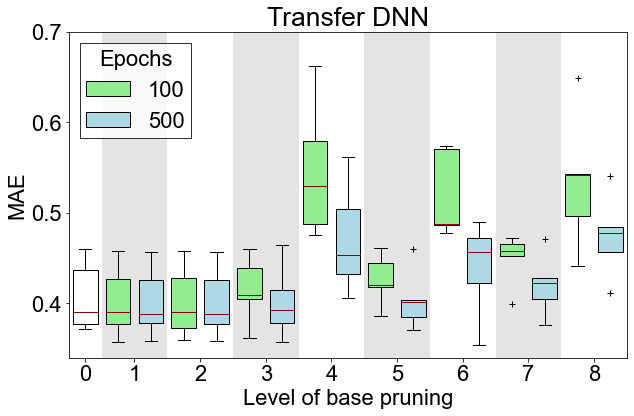

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

plt.figure(facecolor='white', figsize=(10,6), dpi=72)
plt.rc('font', weight='normal', size=22, family='Arial')

groupings = levels_aggregated.groupby(by=['level', 'epoch'])
bplot = plt.boxplot(groupings.mae.apply(list).values, patch_artist=True, widths=0.75, sym='+', medianprops={'color':'darkred'})
plt.xticks([1] + list(np.arange(2.5, 17.5, 2)), labels=list(range(0, 9)))

plt.title('Transfer DNN')
plt.ylim(.34, 0.7)
plt.ylabel('MAE')
plt.xlabel('Level of base pruning')

j = 0
for patch, (i, df) in zip(bplot['boxes'], groupings):
    j += 1
    
    #Making background, colors, etc.. distinctive
    if df['epoch'].iloc[0] == 100:
        patch.set_facecolor('lightgreen')
        
        if j % 4 == 1:
            rect = patches.Rectangle((0.5+j,0.34), 2, 0.4, facecolor='lightgrey', edgecolor='none', alpha=0.6)
            plt.gca().add_patch(rect)
            
    elif df['epoch'].iloc[0] == 500:
        patch.set_facecolor('lightblue')
        
    else:
        j -= 1
        patch.set_facecolor('white')

plt.legend((Patch(facecolor='lightgreen', edgecolor='black'), Patch(facecolor='lightblue', edgecolor='black')),
           ('100', '500'),
           title='Epochs', loc='upper left', edgecolor='black', borderpad=0.3, fancybox=False)

We conclude that transfer learning via small adjustments to the base model results in a positive transfer of knowledge to the target domain.

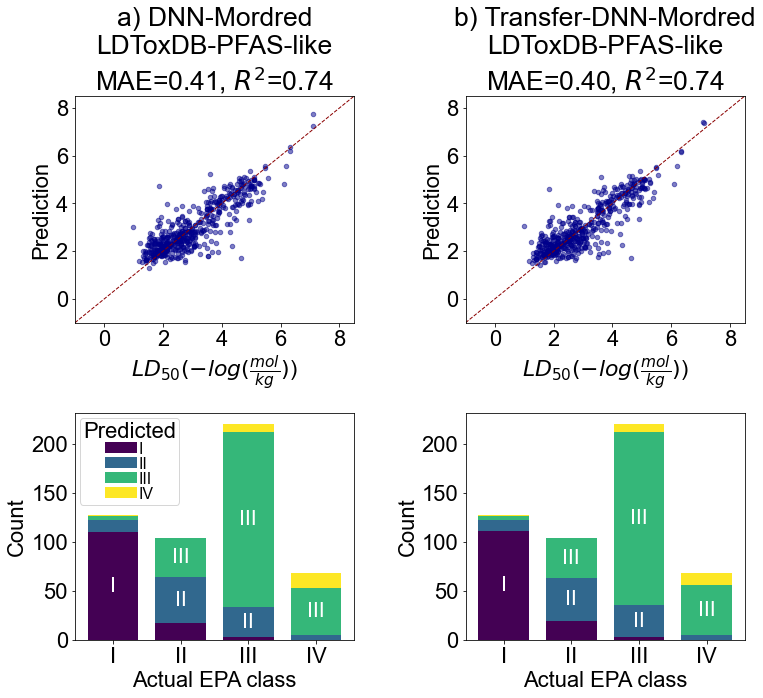

In [45]:
import matplotlib
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=72)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.rc('figure', facecolor='white')
plt.rc('font', family='Arial', weight='normal')
plt.rc('axes', labelsize=22, facecolor='white')
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=20)

baseline_results = pd.concat([pd.read_csv(path)
                        for path in glob('../data/benchmark-models/dnn_mordred*_random*.csv')])

# Regression plots--

# Only look at PFAS results from the benchmark models; others are irrelevant for target task
baseline_results['rd_mol'] = baseline_results.smiles.apply(Chem.MolFromSmiles)
baseline_results['is_pfas_like'] = baseline_results.rd_mol.apply(count_cf_bonds) >= 2
baseline_results = baseline_results.loc[baseline_results.is_pfas_like]

pfas_mae = mean_absolute_error(baseline_results['actual_neglogld50'], baseline_results['prediction_neglogld50'])
pfas_r2 = r2_score(baseline_results['actual_neglogld50'], baseline_results['prediction_neglogld50'])

axes[0][0].scatter(baseline_results['actual_neglogld50'], baseline_results['prediction_neglogld50'], s=20,
                alpha = 0.5, color='darkblue')
#y=x
axes[0][0].plot([0,1],[0,1], transform=axes[0][0].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
axes[0][0].set_title('a) DNN-Mordred\nLDToxDB-PFAS-like\n' + 'MAE=%0.2f, $R^2$=%0.2f' % (pfas_mae, pfas_r2))
axes[0][0].set_xlabel("$LD_{50} (-log(\\frac{mol}{kg})$)")
axes[0][0].set_ylabel("Prediction")
axes[0][0].set_xlim((-1,8.5))
axes[0][0].set_ylim((-1, 8.5))
axes[0][0].set_xticks([0,2,4,6,8])

transfer_results = pd.concat([pd.read_csv(path)
                        for path in glob('../data/transfer-learning/dnn_mordred*_random*level0_epochs100_*.csv')])

pfas_mae = mean_absolute_error(transfer_results['actual_neglogld50'], transfer_results['prediction_neglogld50'])
pfas_r2 = r2_score(transfer_results['actual_neglogld50'], transfer_results['prediction_neglogld50'])

axes[0][1].scatter(transfer_results['actual_neglogld50'], transfer_results['prediction_neglogld50'], s=20,
                  alpha = 0.5, color='darkblue')
#y=x
axes[0][1].plot([0,1],[0,1], transform=axes[0][1].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
axes[0][1].set_title('b) Transfer-DNN-Mordred\nLDToxDB-PFAS-like\n' + 'MAE=%0.2f, $R^2$=%0.2f' % (pfas_mae, pfas_r2))
axes[0][1].set_xlabel("$LD_{50} (-log(\\frac{mol}{kg})$)")
axes[0][1].set_ylabel("Prediction")
axes[0][1].set_xlim((-1,8.5))
axes[0][1].set_ylim((-1, 8.5))
axes[0][1].set_xticks([0,2,4,6,8])

# Confusion plots--

levels = ['I','II','III','IV']

cm = confusion_matrix(baseline_results['actual_epa'].values, baseline_results['prediction_epa'].values)

for i, pred_level in enumerate(levels):
    for j, level in enumerate(levels):
            if pred_level == level:
                axes[1][0].bar(j, cm[j][i], bottom=np.sum(cm[j][:i]), width=0.75,
                               label=pred_level, color=matplotlib.cm.get_cmap('viridis')(i/3), edgecolor='none')
            else:
                axes[1][0].bar(j, cm[j][i], bottom=np.sum(cm[j][:i]), width=0.75,
                               color=matplotlib.cm.get_cmap('viridis')(i/3), edgecolor='none')
                               
            if cm[j][i] > 500/20:
                axes[1][0].text(j, np.sum(cm[j][:i])+cm[j][i]*0.5, pred_level, ha='center',  va='center', color='white', size='21')

axes[1][0].set_xticks([0,1,2,3])
axes[1][0].set_xticklabels(levels)
axes[1][0].set_xlabel("Actual EPA class")
axes[1][0].set_ylabel("Count")

cm = confusion_matrix(transfer_results['actual_epa'].values, transfer_results['prediction_epa'].values)

for i, pred_level in enumerate(levels):
    for j, level in enumerate(levels):
            if pred_level == level:
                axes[1][1].bar(j, cm[j][i], bottom=np.sum(cm[j][:i]), width=0.75,
                               label=pred_level, color=matplotlib.cm.get_cmap('viridis')(i/3), edgecolor='none')
            else:
                axes[1][1].bar(j, cm[j][i], bottom=np.sum(cm[j][:i]), width=0.75,
                               color=matplotlib.cm.get_cmap('viridis')(i/3), edgecolor='none')
                               
            if cm[j][i] > 500/20:
                axes[1][1].text(j, np.sum(cm[j][:i])+cm[j][i]*0.5, pred_level, ha='center',  va='center', color='white', size='21')

axes[1][1].set_xticks([0,1,2,3])
axes[1][1].set_xticklabels(levels)
axes[1][1].set_xlabel("Actual EPA class")
axes[1][1].set_ylabel("Count")

axes[1][0].legend(loc='upper left', fontsize=16, labelspacing=0, borderaxespad=0.3,
                  columnspacing=0.1, borderpad=0.2, handletextpad=0.1,title='Predicted')